In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sfumato.utils.visualizer import plot_signal_analysis

モノラル

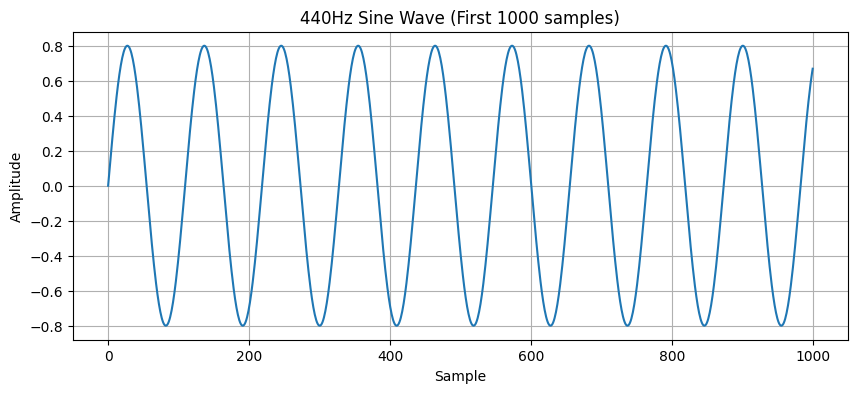

In [19]:
from sfumato.utils.audio_source import AudioSource

# インスタンス化 (48kHz)
source = AudioSource(sample_rate=48000)

# パターンA: 440Hz (A4) の音を 0.1秒作る
tone_data = source.sine_tone(frequency=440.0, duration=0.1)

plt.figure(figsize=(10, 4))
plt.plot(tone_data[:1000])  # 最初の1000サンプルだけ表示
plt.title("440Hz Sine Wave (First 1000 samples)")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

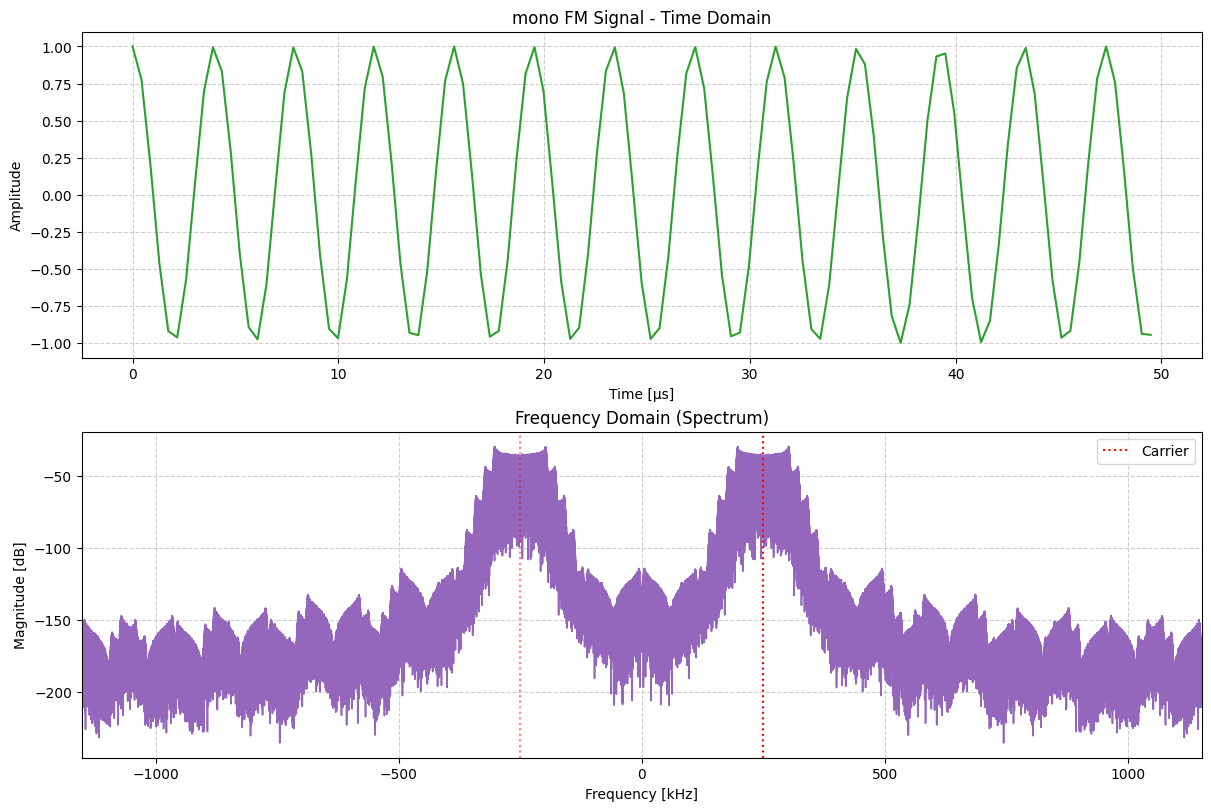

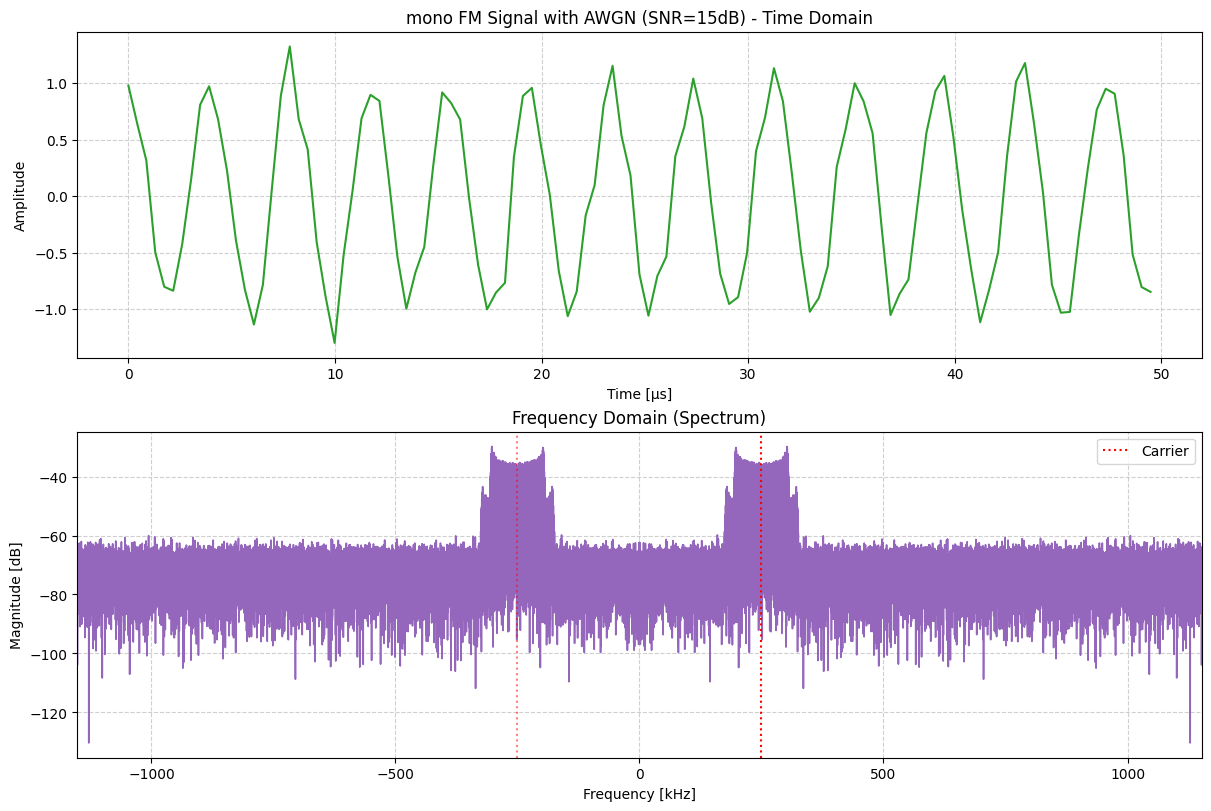

In [20]:
from sfumato import transmitter
from sfumato.channnel import add_awgn

tx = transmitter.FmTransmitter()
mono_signal_clean = tx.modulate(tone_data)
mono_signal_noisy = add_awgn(mono_signal_clean, snr_db=15.0)

plot_signal_analysis(
    mono_signal_clean,
    fs=tx.rf_fs,
    title="mono FM Signal",
    zoom_usec=50,
    carrier_freq=tx.fc,
)

plot_signal_analysis(
    mono_signal_noisy,
    fs=tx.rf_fs,
    title="mono FM Signal with AWGN (SNR=15dB)",
    zoom_usec=50,
    carrier_freq=tx.fc,
)

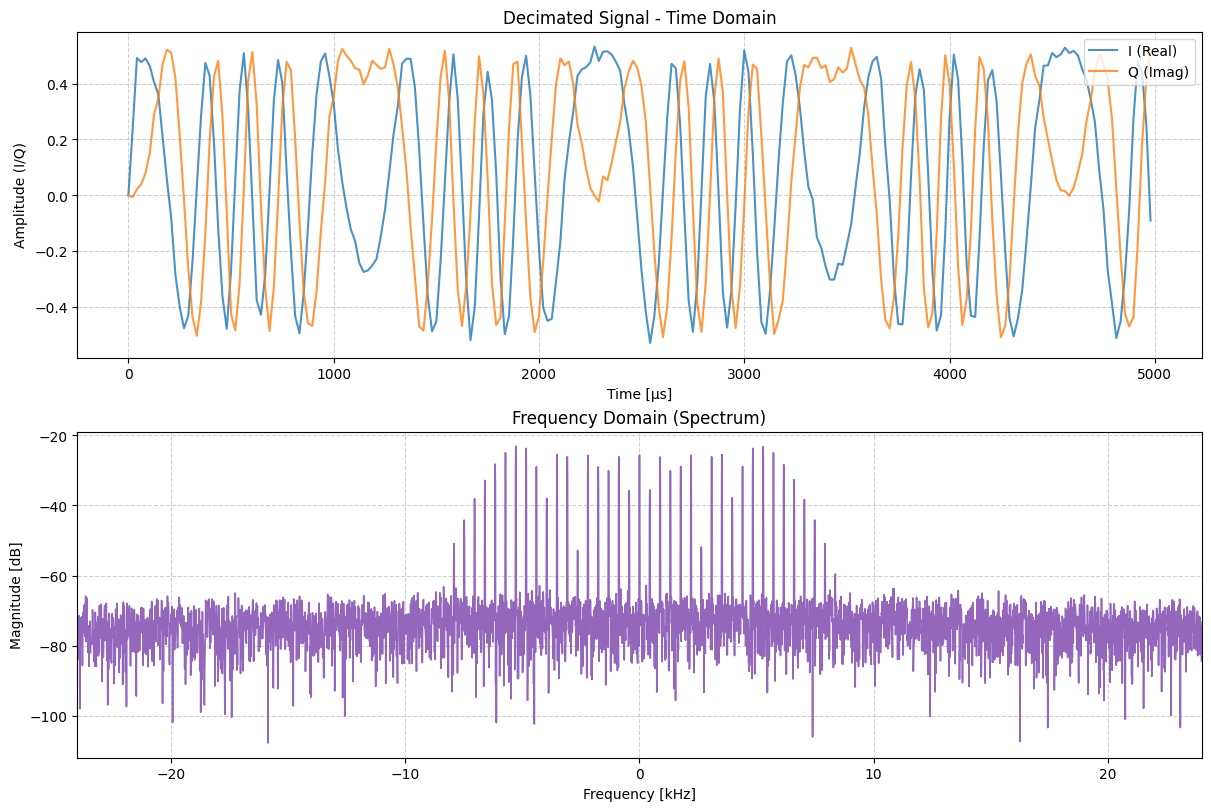

In [6]:
from sfumato import reciever

rx = reciever.FmReceiver()

decimated_iq = rx.process(mono_signal_noisy)
plot_signal_analysis(
    decimated_iq,
    fs=rx.audio_fs,
    title="Decimated Signal",
    zoom_usec=5000,
    xlim_freq=[-24, 24],
)

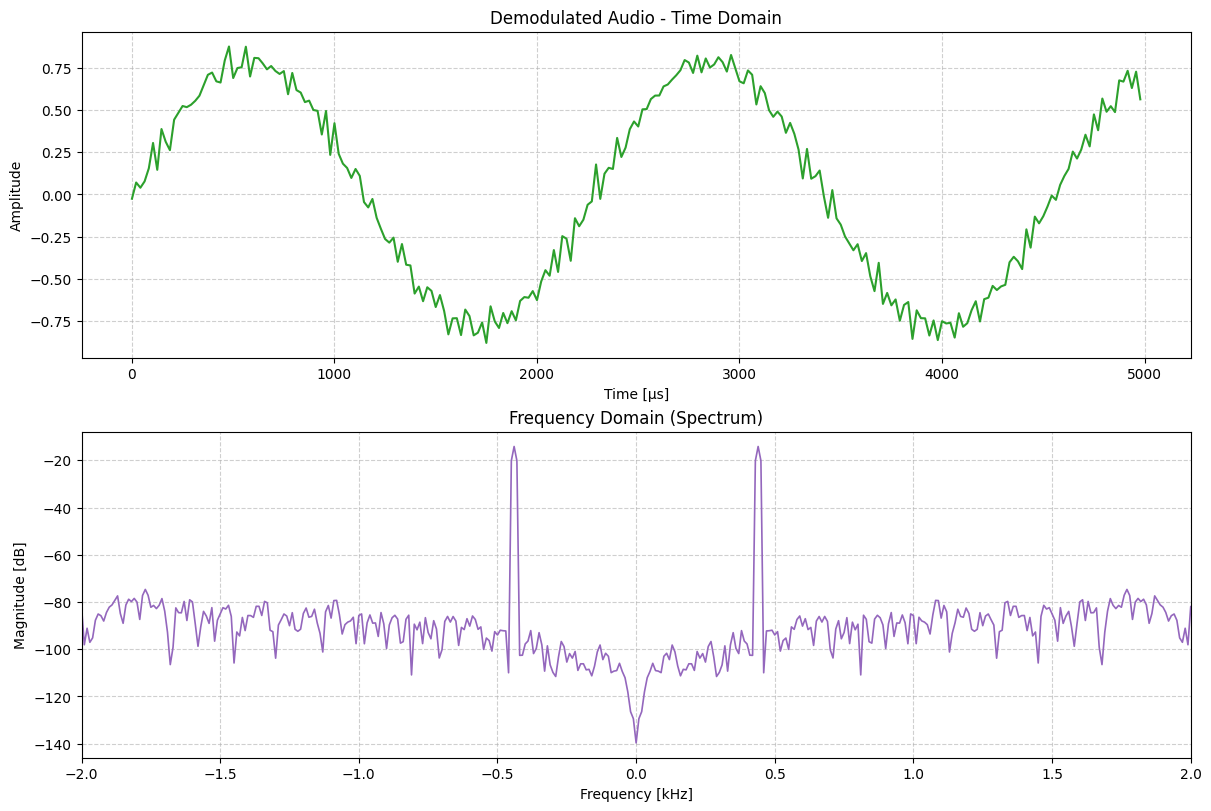

In [7]:
demodulated_audio = rx._demodulate(decimated_iq)
plot_signal_analysis(
    demodulated_audio,
    fs=rx.audio_fs,
    title="Demodulated Audio",
    zoom_usec=5000,
    xlim_freq=[-2, 2],
)

ステレオ

In [34]:
from sfumato import transmitter
from sfumato.channnel import add_awgn

tx = transmitter.FmTransmitter()

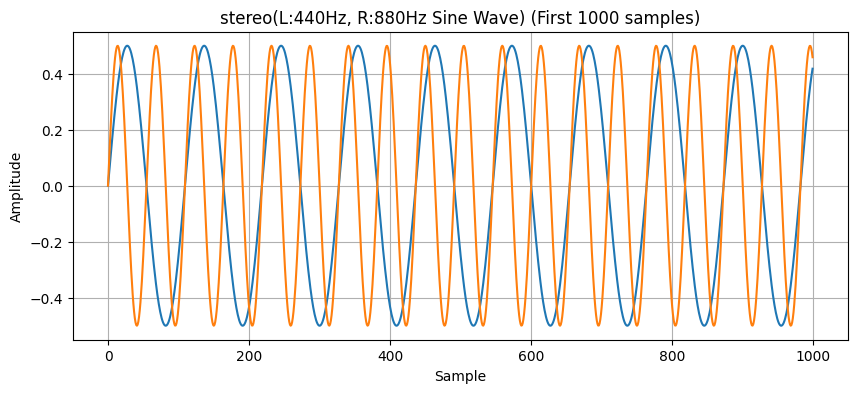

In [35]:
from sfumato.utils.audio_source import AudioSource

# インスタンス化 (48kHz)
source = AudioSource(sample_rate=48000)

tone_data = source.stereo_sine_tone(freq_l=440.0, freq_r=880.0,  duration=0.1)

plt.figure(figsize=(10, 4))
plt.plot(tone_data[:1000])  # 最初の1000サンプルだけ表示
plt.title("stereo(L:440Hz, R:880Hz Sine Wave) (First 1000 samples)")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

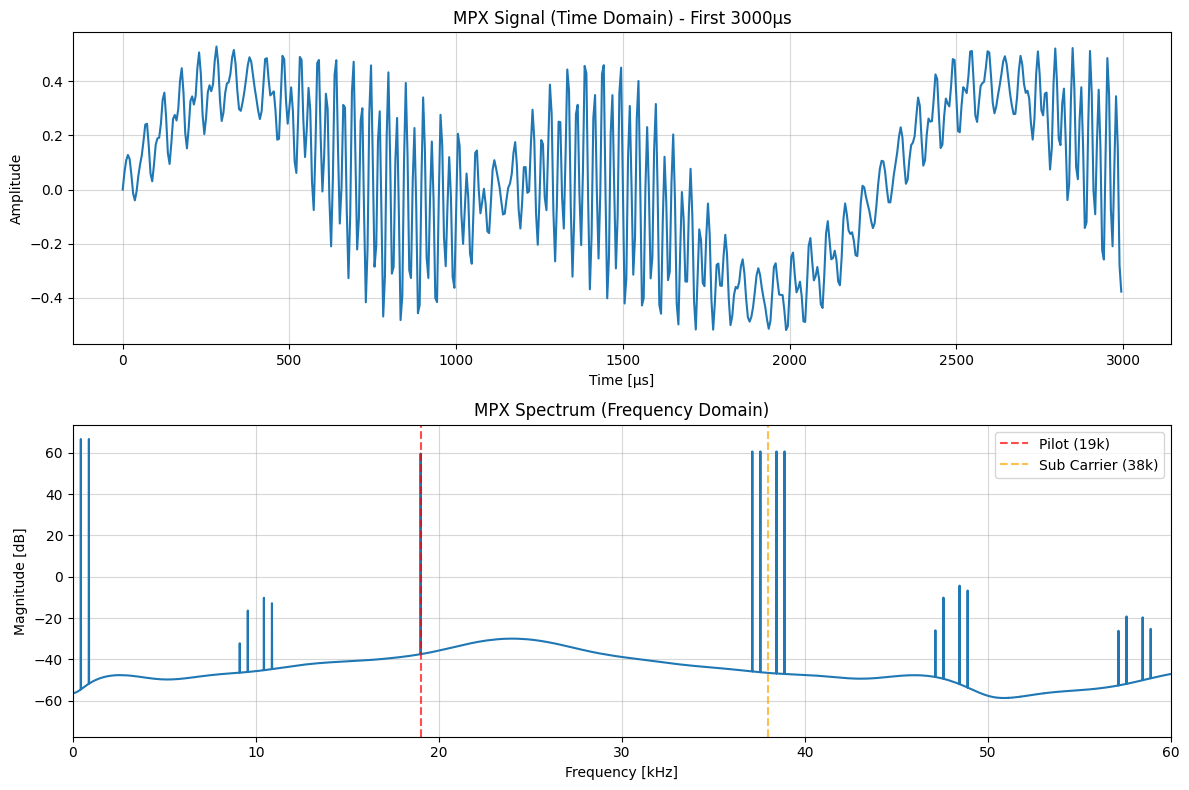

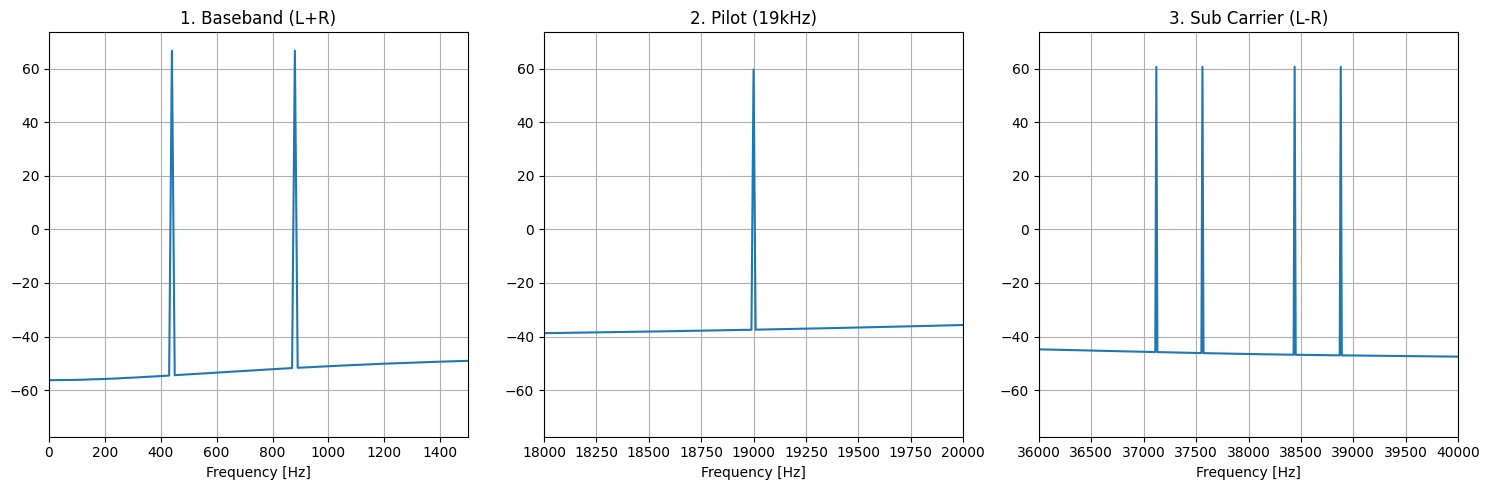

In [41]:
# --- 1. MPX信号の生成 ---
l_ch = tone_data[:, 0]
r_ch = tone_data[:, 1]

# アップサンプリング (Audio 48k -> MPX 192k)
l_upsampled = tx._upsample(l_ch, tx.audio_fs, tx.mpx_fs)
r_upsampled = tx._upsample(r_ch, tx.audio_fs, tx.mpx_fs)

# MPX信号 (コンポジット) の生成
mpx_signal = tx._generate_mpx(l_upsampled, r_upsampled)

# --- 2. 可視化 ---

def analyze_mpx(signal, fs):
    N = len(signal)
    t = np.arange(N) / fs
    
    # 周波数解析 (FFT)
    freqs = np.fft.rfftfreq(N, d=1/fs)
    mag = np.abs(np.fft.rfft(signal))
    mag_db = 20 * np.log10(mag + 1e-12) # ゼロ除算防止
    
    plt.figure(figsize=(12, 8))
    
    # --- 上段: 時間波形 ---
    plt.subplot(2, 1, 1)
    # パイロット(19kHz)の周期は約52μs。
    subset_samples = int(fs * 0.003)
    plt.plot(t[:subset_samples] * 1e6, signal[:subset_samples])
    plt.title("MPX Signal (Time Domain) - First 3000µs")
    plt.xlabel("Time [µs]")
    plt.ylabel("Amplitude")
    plt.grid(True, alpha=0.5)
    
    # --- 下段: 周波数スペクトル ---
    plt.subplot(2, 1, 2)
    plt.plot(freqs / 1000, mag_db)
    plt.title("MPX Spectrum (Frequency Domain)")
    plt.xlabel("Frequency [kHz]")
    plt.ylabel("Magnitude [dB]")
    plt.grid(True, which='both', alpha=0.5)
    
    # 重要なポイントに赤線を引く
    plt.axvline(19, color='red', linestyle='--', alpha=0.7, label='Pilot (19k)')
    plt.axvline(38, color='orange', linestyle='--', alpha=0.7, label='Sub Carrier (38k)')
    plt.xlim(0, 60) # 60kHzまで見えれば十分
    plt.legend()
    
    plt.tight_layout()
    plt.show()

analyze_mpx(mpx_signal, fs=tx.mpx_fs)

def analyze_mpx_zoomed(signal, fs):
    N = len(signal)
    freqs = np.fft.rfftfreq(N, d=1/fs)
    mag = np.abs(np.fft.rfft(signal))
    mag_db = 20 * np.log10(mag + 1e-12)

    plt.figure(figsize=(15, 5))

    # 1. 低域 (Baseband)
    plt.subplot(1, 3, 1)
    plt.plot(freqs, mag_db)
    plt.xlim(0, 1500)  # 0Hz - 1.5kHz
    plt.title("1. Baseband (L+R)")
    plt.xlabel("Frequency [Hz]")
    plt.grid(True)
    # ここに 440Hz, 880Hz があるはず

    # 2. パイロット (Pilot)
    plt.subplot(1, 3, 2)
    plt.plot(freqs, mag_db)
    plt.xlim(18000, 20000) # 18k - 20k
    plt.title("2. Pilot (19kHz)")
    plt.xlabel("Frequency [Hz]")
    plt.grid(True)

    # 3. サブキャリア (L-R Sidebands)
    plt.subplot(1, 3, 3)
    plt.plot(freqs, mag_db)
    plt.xlim(36000, 40000) # 36k - 40k
    plt.title("3. Sub Carrier (L-R)")
    plt.xlabel("Frequency [Hz]")
    plt.grid(True)
    # ここに 4本のサイドバンドが見えるはず

    plt.tight_layout()
    plt.show()

# 実行
analyze_mpx_zoomed(mpx_signal, fs=tx.mpx_fs)

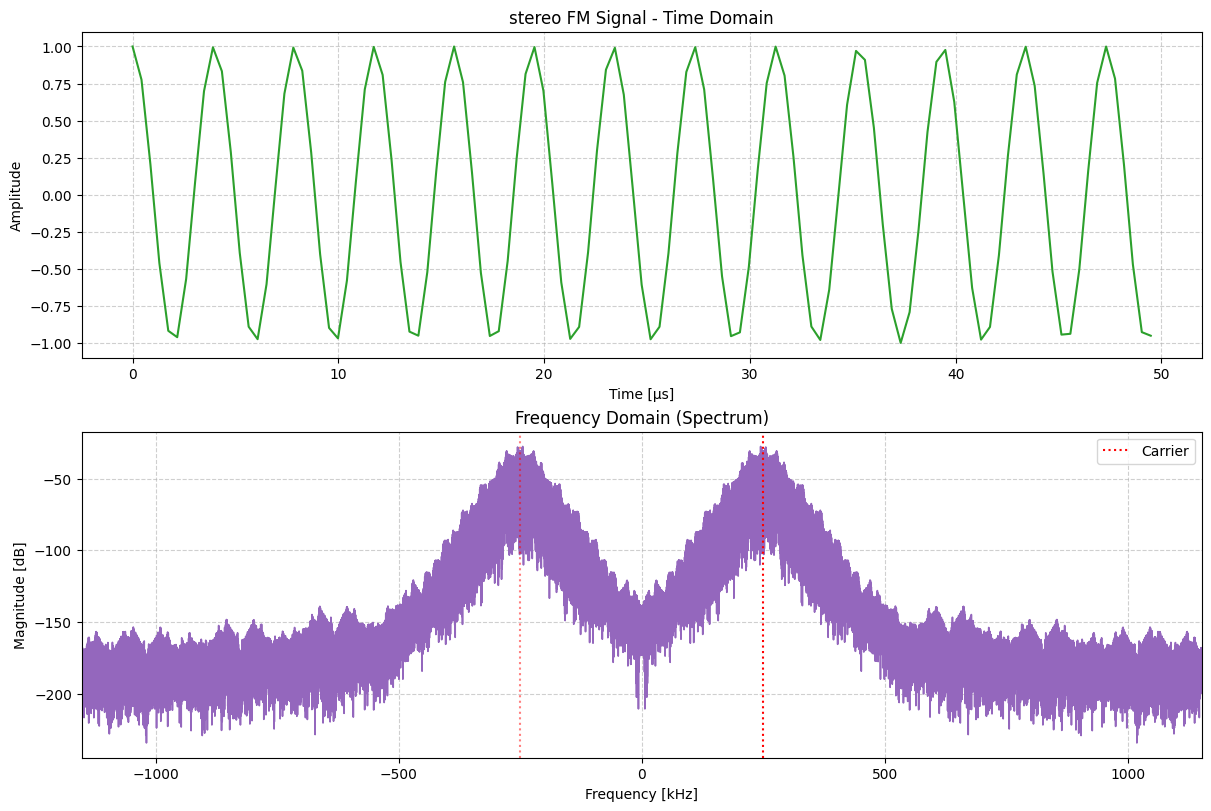

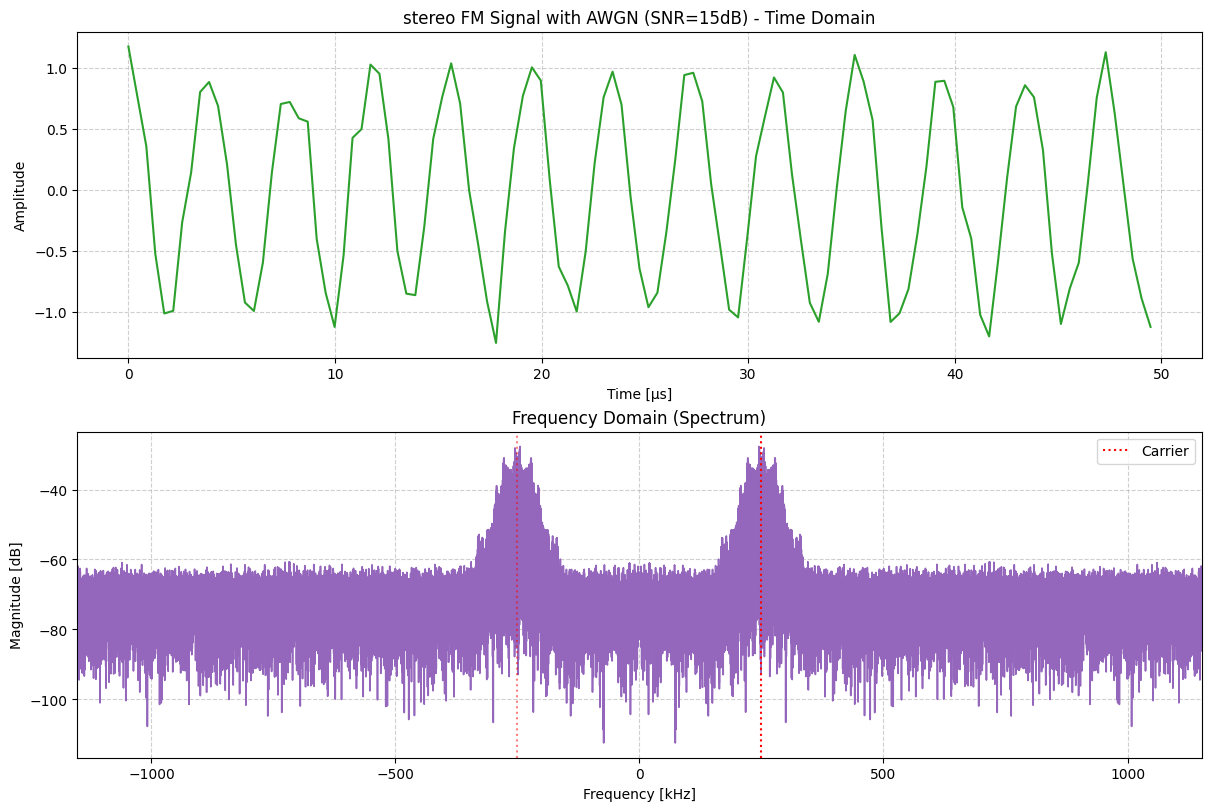

In [37]:

stereo_signal_clean = tx.modulate(tone_data)
stereo_signal_noisy = add_awgn(stereo_signal_clean, snr_db=15.0)

plot_signal_analysis(
    stereo_signal_clean,
    fs=tx.rf_fs,
    title="stereo FM Signal",
    zoom_usec=50,
    carrier_freq=tx.fc,
)

plot_signal_analysis(
    stereo_signal_noisy,
    fs=tx.rf_fs,
    title="stereo FM Signal with AWGN (SNR=15dB)",
    zoom_usec=50,
    carrier_freq=tx.fc,
)